In [1]:

from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import re
import string
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
consumer_key="XXXXXXXXXXXXXXx"
consumer_secret="XXXXXXXXX"
access_token="XXXXXXXXXXXXXXXXXXXX"
access_token_secret="XXXXXXXXXXXXXXXXXXXXX"
auth= tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_token_secret)
api=tweepy.API(auth)

In [2]:
def percentage(part,whole):
    return 100*float(part)/float(whole)
def create_wordcloud(text):
    stopwords=set(STOPWORDS)
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(text))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=["Total","Percentage"])
def analysing():
    keyword=input("Give a account name or hastag without('@,#'): ")
    noOfTweet=int(input("How many tweet ?: "))
    tweets=tweepy.Cursor(api.search_tweets,q=keyword,lang="en").items(noOfTweet)
    positive=0
    negative=0
    neutral=0
    polarity=0
    tweet_list =[]
    neutral_list=[]
    negative_list=[]
    positive_list=[]
    for tweet in tweets:
        
        
        tweet_list.append(tweet.text)
        analysis = TextBlob(tweet.text)
        score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
        neg = score['neg']
        pos = score['pos']
        neu = score['neu']
        comp = score['compound']
        polarity += analysis.sentiment.polarity

        if neg > pos:
            negative_list.append(tweet.text)
            negative+=1
        elif pos > neg:
            positive_list.append(tweet.text)
            positive+=1
        elif pos == neg:
            neutral_list.append(tweet.text)
            neutral += 1

    positive = percentage(positive , noOfTweet)
    negative = percentage(negative , noOfTweet)
    neutral =  percentage(neutral  , noOfTweet)
    polarity = percentage(polarity , noOfTweet)
    positive = format(positive,".1f")
    negative = format(negative,".1f")
    neutral = format(neutral,".1f")

    positive_list = pd.DataFrame(positive_list)
    negative_list = pd.DataFrame(negative_list)
    neutral_list = pd.DataFrame(neutral_list)


    tweet_list    = pd.DataFrame(tweet_list)
    neutral_list  = pd.DataFrame(neutral_list)
    negative_list = pd.DataFrame(negative_list)
    positive_list = pd.DataFrame(positive_list)
    print("total tweet: ",len(tweet_list))
    print("Positive tweets of Num: ",len(positive_list))
    print("Neutral  tweets of Num: ",len(neutral_list))
    print("Negative tweets of Num: ",len(negative_list))
        
    #Pie Cart
    labels = ["Positive ["+str(positive)+"%]" , "Neutral ["+str(neutral)+"%]","Negative ["+str(negative)+"%]"]
    sizes  = [positive, neutral, negative]
    colors = ["yellowgreen", "blue","red"]
    patches, texts = plt.pie(sizes,colors=colors, startangle=90)
    plt.style.use("default")
    plt.legend(labels)
    plt.title("Sentiment Analysis Result for keyword= "+keyword+"" )
    plt.axis("equal")
    plt.show()
        
    tweet_list.drop_duplicates(inplace = True)
        
    tw_list = pd.DataFrame(tweet_list)
    tw_list ["text"]= tw_list[0]
    #Removing RT, Punctuation etc
    remove_rt=lambda x:re.sub('RT @\w+:'," ",x)
    #rt= lambda x:re.sub("@[^\w\.@]"," ",x)
    rt = lambda x: re.sub("(@[A-Za-z0–9]+)|(\w+:\/\/\S+)|(#\w+:)|(\n)|(_\w+)"," ",x)
    tw_list["text"]= tw_list.text.map(remove_rt).map(rt)
    tw_list["text"]= tw_list.text.str.lower()
    print("--------------------------FIRST 10 TWEETS-------------------------------------")
    print(tw_list.head(10))
    print("------------------------------------------------------------------------------")    
    #Now  calculating  to sentiments of tweets(+,-,0)
        
    tw_list[["polarity","subjectivity"]] = tw_list["text"].apply(lambda Text:pd.Series(TextBlob(Text).sentiment))
    for index,row in tw_list["text"].iteritems():
        score = SentimentIntensityAnalyzer().polarity_scores(row)
        neg   = score["neg"]
        neu   = score["neu"]
        pos   = score["pos"]
        comp  = score["compound"]
        if   neg > pos:
            tw_list.loc[index,"sentiment"]="Negative"
        elif pos > neg:
            tw_list.loc[index,"sentiment"]="Positive"
        else:
            tw_list.loc[index,"sentiment"]="Neutral"
        tw_list.loc[index,"neg"]=neg
        tw_list.loc[index,"neu"]=neu
        tw_list.loc[index,"pos"]=pos
        tw_list.loc[index,"compound"]=comp
    
    print(tw_list.head(10))
    #Creating new data frames for all sentiments (positive, negative and neutral)
    tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
    tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
    tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]
    #Count_values for sentiment
    print(count_values_in_column(tw_list,"sentiment"))
    
        
    #A new Pie Cart
    pichart = count_values_in_column(tw_list,"sentiment")
    names= pichart.index
    size=pichart["Percentage"]
 
    # Create a circle for the center of the plot
    my_circle=plt.Circle( (0,0), 0.7, color="white")
    plt.pie(size, labels=names, colors=["red","green","blue"])
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()
    #Creating wordcloud for all tweets
    create_wordcloud(tw_list["text"].values)
    
    tw_list["punct"] = tw_list["text"].apply(lambda x: remove_punct(x))
    tw_list['tokenized'] = tw_list['punct'].apply(lambda x: tokenization(x.lower()))
    tw_list['nonstop'] = tw_list['tokenized'].apply(lambda x: remove_stopwords(x))
    tw_list['stemmed'] = tw_list['nonstop'].apply(lambda x: stemming(x))
    
    print(tw_list.head())
    
    countVectorizer = CountVectorizer(analyzer=clean_text) 
    countVector = countVectorizer.fit_transform(tw_list["text"])
    print("{} Number of reviews has {} words".format(countVector.shape[0], countVector.shape[1]))
    count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
    print(count_vect_df.head())
    
    #MOST WORDS
    count = pd.DataFrame(count_vect_df.sum())
    countdf = count.sort_values(0,ascending=False).head(20)
    print(countdf[1:11])
    
    # This part of codes for lemmitasion of word
    #Removing Punctuation
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub("[0–9]+", "", text)
    return text

#Appliyng tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text

#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
    
    
    #Appliyng Stemmer
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text
    
#Cleaning Text
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text
    
    
    
    
    


Give a account name or hastag without('@,#'): biden
How many tweet ?: 1000
total tweet:  1000
Positive tweets of Num:  347
Neutral  tweets of Num:  251
Negative tweets of Num:  402


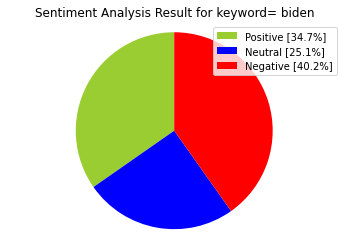

--------------------------FIRST 10 TWEETS-------------------------------------
                                                   0  \
0  RT @BoSnerdley: Gabbard: Biden should not be c...   
1  RT @HillReporter: New Poll Shows Biden Clearly...   
2  RT @kickingcrowns: @PolitiBunny You mean when ...   
3  RT @debostic: Ortagus and Vinograd founded “GO...   
4  RT @MarshaBlackburn: Joe and Hunter Biden prof...   
5  RT @davidmweissman: Why is Ron DeSantis taking...   
6  RT @StephenM: This is a massive, massive scoop...   
7  RT @votevets: STATEMENT OF VOTEVETS SENIOR ADV...   
8  RT @Yonas5j: Drone strikes targeting civilians...   
9  RT @bballfanatic45: @excellentw0w @therecount ...   

                                                text  
0    gabbard: biden should not be choosing scotus...  
1    new poll shows biden clearly ahead of trump ...  
2      you mean when biden rescinded the 340b exe...  
3    ortagus and vinograd founded “go advisors”, ...  
4    joe and hunter biden pro

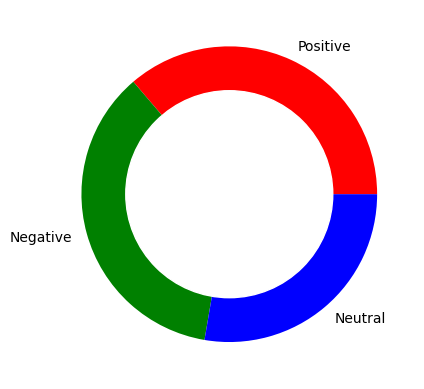

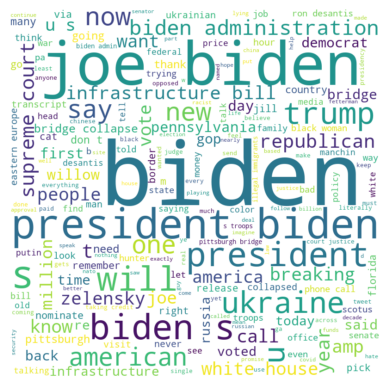

                                                   0  \
0  RT @BoSnerdley: Gabbard: Biden should not be c...   
1  RT @HillReporter: New Poll Shows Biden Clearly...   
2  RT @kickingcrowns: @PolitiBunny You mean when ...   
3  RT @debostic: Ortagus and Vinograd founded “GO...   
4  RT @MarshaBlackburn: Joe and Hunter Biden prof...   

                                                text  polarity  subjectivity  \
0    gabbard: biden should not be choosing scotus...  0.000000      0.000000   
1    new poll shows biden clearly ahead of trump ...  0.118182      0.418939   
2      you mean when biden rescinded the 340b exe... -0.312500      0.687500   
3    ortagus and vinograd founded “go advisors”, ... -0.200000      0.400000   
4    joe and hunter biden profited off of shady b... -0.125000      0.312500   

  sentiment   neg    neu    pos  compound  \
0   Neutral  0.00  1.000  0.000    0.0000   
1  Positive  0.00  0.803  0.197    0.4019   
2   Neutral  0.00  1.000  0.000    0.0000   
3 

In [3]:
analysing()

